# 📘 Define DMRs from ranked CpG List and Positional Data
This notebook takes:
- A list of significant CpGs (`cpg_list.txt`)
- A CpG position file (`cpg_positions.csv` with `CpG_ID`, `chr`, `pos` columns)

Find differentially methylated CpGs by running FDR correction on their p-values gaind from paired t-test analyssi. It groups CpGs into DMRs using a genomic distance threshold (default 500 bp).

#Input files expected:
- `sorted_CpGs.csv`: Sorted differentially methylated CpGs (Columns: CpG,	delta_beta,	p_value)
- `cpg_positions.csv.zip`: Downloaded and parsed the following file to get columns CpG_ID, chr, pos, UCSC_RefGene_Name, Regulatory_Feature_Group. "https://webdata.illumina.com/downloads/productfiles/humanmethylation450/humanmethylation450_15017482_v1-2.csv"

#Output produced:
- `DMR_definition.csv`: Coordination of each DMR with CpGs it covers (Columns: DMR_ID, chr, start, end, num_CpGs, CpG_IDs)



## 1) Setup & upload

In [ ]:
import pandas as pd
from statsmodels.stats.multitest import multipletests

from google.colab import files

# Upload helper
from google.colab import files


In [ ]:
# If running in Colab, use this to upload files. Otherwise ensure files exist in working directory.
try:
    from google.colab import files
    IN_COLAB = True
except Exception:
    IN_COLAB = False
print('IN_COLAB =', IN_COLAB)

if IN_COLAB:
    print('Please upload sorted_CpGs.csv.zip, cpg_positions.csv.zip')
    uploaded = files.upload()
    print('Uploaded:', list(uploaded.keys()))


IN_COLAB = True
Please upload sorted_CpGs.csv.zip, cpg_positions.csv.zip


Saving cpg_positions.csv.zip to cpg_positions.csv.zip
Saving sorted_CpGs.csv.zip to sorted_CpGs.csv (3).zip
Uploaded: ['cpg_positions.csv.zip', 'sorted_CpGs.csv (3).zip']


In [ ]:
import zipfile
import pandas as pd

# Replace with your actual zip file name
zip_filename = 'sorted_CpGs.csv.zip' # This is the uploaded filename
csv_name_in_zip = 'top_CpGs.csv' # This is the actual filename inside the zip

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    # Assume the zip contains ONE csv file
    csv_name = zip_ref.namelist()[0]
    zip_ref.extract(csv_name_in_zip)  # Extracts to current directory

# Load into DataFrame
cpg_list = pd.read_csv(csv_name_in_zip)
cpg_list = cpg_list.rename(columns={"CpG": "CpG_ID"}) # For consistency
cpg_list.head()

,CpG_ID,delta_beta,p_value
0,cg04864807,0.513935,4.491369e-22
1,cg11201447,-0.436955,5.731186e-20
2,cg25247520,-0.403264,5.732552e-20
3,cg08443563,-0.339449,5.920719e-20
4,cg12595013,0.321510,1.225674e-19


##2) FDR corresction to find top CpGs, plus some visualizations

In [ ]:
# Run FDR correction to correct for multiple test and choose top CpGs based on delta_beta value and fdr_p_value

# Apply FDR correction
rejected, fdr_corrected_pvals, _, _ = multipletests(cpg_list['p_value'], alpha=0.05, method='fdr_bh')

# Append results
cpg_list['fdr_p_value'] = fdr_corrected_pvals
cpg_list['fdr_significant'] = rejected

# Save all CpGs
cpg_list.to_csv('top_cpg_with_fdr.csv', index=False)

# Save only significant CpGs
cpg_list[cpg_list['fdr_significant']].to_csv('significant_cpgs_fdr.csv', index=False)


print(f"✅ Total CpGs: {len(cpg_list)}, Significant after FDR: {cpg_list['fdr_significant'].sum()}")
cpg_list.head()

# Count how many CpGs delta_beta bigger than 20% and significant FDR
cpg_list_filtered = cpg_list[(cpg_list['delta_beta'].abs() >= 0.2) & (cpg_list['fdr_p_value'] < 0.05)]
print(f"✅ Total CpGs: {len(cpg_list)}, Significant after FDR and beta_value: {cpg_list_filtered['fdr_significant'].sum()}")
cpg_list_filtered.head()

✅ Total CpGs: 395636, Significant after FDR: 156440
✅ Total CpGs: 395636, Significant after FDR and beta_value: 10450


,CpG_ID,delta_beta,p_value,fdr_p_value,fdr_significant
0,cg04864807,0.513935,4.491369e-22,1.776947e-16,True
1,cg11201447,-0.436955,5.731186e-20,5.856124e-15,True
2,cg25247520,-0.403264,5.732552e-20,5.856124e-15,True
3,cg08443563,-0.339449,5.920719e-20,5.856124e-15,True
4,cg12595013,0.321510,1.225674e-19,9.698417e-15,True


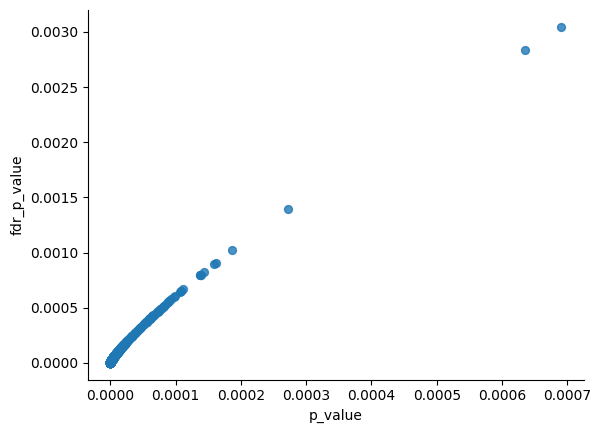

In [ ]:
# @title p_value vs fdr_p_value

from matplotlib import pyplot as plt
cpg_list_filtered.plot(kind='scatter', x='p_value', y='fdr_p_value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

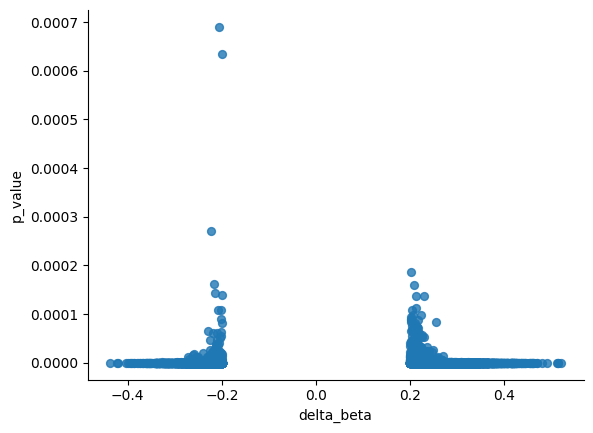

In [ ]:
# @title delta_beta vs p_value

from matplotlib import pyplot as plt
cpg_list_filtered.plot(kind='scatter', x='delta_beta', y='p_value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

##3) DMR definition by clustering nearby CpGs based on genomic proximity

In [ ]:
import zipfile
import pandas as pd

# Replace with your actual zip file name
zip_filename = 'cpg_positions.csv.zip'

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    # Assume the zip contains ONE csv file
    csv_name = zip_ref.namelist()[0]
    zip_ref.extract('cpg_positions.csv')  # Extracts to current directory

# Load into DataFrame, specifying column names
pos_df = pd.read_csv('cpg_positions.csv')
print(f"✅ Loaded {len(pos_df)} CpG positions.")
pos_df.head()

✅ Loaded 482421 CpG positions.


/tmp/ipython-input-290309517.py:13: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  pos_df = pd.read_csv('cpg_positions.csv')


,CpG_ID,chr,pos,UCSC_RefGene_Name,Regulatory_Feature_Group
0,cg00035864,Y,8553009,TTTY18,NaN
1,cg00050873,Y,9363356,TSPY4;FAM197Y2,NaN
2,cg00061679,Y,25314171,DAZ1;DAZ4;DAZ4,NaN
3,cg00063477,Y,22741795,EIF1AY,NaN
4,cg00121626,Y,21664296,BCORL2,NaN


In [ ]:
## Merge positional data with top CpGs
pos_df.columns
df = pos_df[['CpG_ID', 'chr', 'pos']].merge(cpg_list_filtered, on='CpG_ID')

# Sort by chromosome and position
df = df.sort_values(by=['chr', 'pos']).reset_index(drop=True)
print(f"✅ {len(df)} CpGs matched with positions.")

✅ 10450 CpGs matched with positions.


In [ ]:
# Group CpGs into DMRs
DMRs = []
current_dmr = []
distance_threshold = 500  # base pairs
min_cpgs_per_dmr = 3

for i in range(len(df)):
    if not current_dmr:
        current_dmr.append(df.iloc[i])
    else:
        prev = current_dmr[-1]
        curr = df.iloc[i]
        if curr['chr'] == prev['chr'] and (curr['pos'] - prev['pos']) <= distance_threshold:
            current_dmr.append(curr)
        else:
            if len(current_dmr) >= min_cpgs_per_dmr:
                DMRs.append(pd.DataFrame(current_dmr))
            current_dmr = [curr]

# Add last group
if len(current_dmr) >= min_cpgs_per_dmr:
    DMRs.append(pd.DataFrame(current_dmr))
print(f"✅ Found {len(DMRs)} DMRs")

✅ Found 824 DMRs


In [ ]:
dmr_list = []
for i, dmr in enumerate(DMRs):
    dmr_id = f"DMR_{i+1}"
    chr_ = dmr['chr'].iloc[0]
    start = dmr['pos'].min()
    end = dmr['pos'].max()
    cpgs = list(dmr['CpG_ID'])
    dmr_list.append({
        'DMR_ID': dmr_id,
        'chr': chr_,
        'start': start,
        'end': end,
        'num_CpGs': len(cpgs),
        'CpG_IDs': ';'.join(cpgs)
    })

dmr_df = pd.DataFrame(dmr_list)
dmr_df.to_csv('DMR_definition.csv', index=False)
print("✅ Saved DMR_definition.csv")
dmr_df.head()

✅ Saved DMR_definition.csv


,DMR_ID,chr,start,end,num_CpGs,CpG_IDs
0,DMR_1,4,41753439,41754125,3,cg19935850;cg25950325;cg24456654
1,DMR_2,4,41882953,41883164,3,cg27405791;cg20038996;cg18351939
2,DMR_3,4,111549880,111550830,4,cg24005685;cg19370653;cg21299542;cg26831119
3,DMR_4,4,154710421,154710826,4,cg23121156;cg22178613;cg23207990;cg20881942
4,DMR_5,4,155662795,155663311,3,cg26461267;cg21266502;cg21713473


In [ ]:
files.download('DMR_definition.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>